In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
from smt.sampling_methods import LHS
#from torch import linspace
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import time
import pickle

from E_data import IC,BC_L,BC_R,BD_circle
from E_Plotting import E_plot_2d,  loss_plot 

# Full PINN
from E_PINN import NN
from E_PINN_train import pinn_train

# VGPT-PINN
from E_VGPT_PINN import GPT
from E_VGPT_train import gpt_train
from E_VGPT_activation import P

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

#torch.manual_seed(123)
#np.random.seed(123)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
number_of_parameters = 2
number_of_neurons = 5
nu_training = np.linspace(0.24,0.26, number_of_parameters)
rd_neurons    = [1 for i in range(number_of_neurons)] # Neuron parameters
nu =1.4
rd_neurons[0] = 0.25
P_list = np.ones(number_of_neurons, dtype=object)

In [3]:
with open('PINN_Euler_circle020.pkl', 'rb') as f:
    PINN = pickle.load(f)
P_list[0] = PINN[0]
with open('PINN_Euler_circle030.pkl', 'rb') as f:
    PINN = pickle.load(f)
P_list[1] = PINN[0]
with open('PINN_Euler_circle025.pkl', 'rb') as f:
    PINN = pickle.load(f)
P_list[2] = PINN[0]
with open('PINN_Euler_circle023.pkl', 'rb') as f:
    PINN = pickle.load(f)
P_list[3] = PINN[0]
with open('PINN_Euler_circle027.pkl', 'rb') as f:
    PINN = pickle.load(f)
P_list[4] = PINN[0]

In [4]:
num_ib = 1500                                                # Random sampled points from IC0
num_int = 30000                                                # Random sampled points in interior
Tend = 0.4
Lx = 1.5
Ly = 2.0
rx = 1.0
ry = 1.0
#rd = 0.25

xlimits = np.array([[0.0,Tend],[0.0, 0.0], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcL_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [Lx, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcR_train =  sampling(num_ib)


xlimits = np.array([[0.0,Tend],[0.0, Lx], [Ly,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcU_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [0.0, Lx], [0.0,0.0]])
sampling = LHS(xlimits=xlimits)
x_bcD_train =  sampling(num_ib)                                           # Vectorized whole domain

rho_bcL_train, u_bcL_train,v_bcL_train, p_bcL_train = BC_L(x_bcL_train)  
rho_bcR_train, u_bcR_train,v_bcR_train, p_bcR_train = BC_L(x_bcR_train)  

rho_bcL_train = torch.tensor(rho_bcL_train, dtype=torch.float32).to(device)
u_bcL_train = torch.tensor(u_bcL_train, dtype=torch.float32).to(device)
v_bcL_train = torch.tensor(v_bcL_train, dtype=torch.float32).to(device)
p_bcL_train = torch.tensor(p_bcL_train, dtype=torch.float32).to(device)

rho_bcR_train = torch.tensor(rho_bcR_train, dtype=torch.float32).to(device)
u_bcR_train = torch.tensor(u_bcR_train, dtype=torch.float32).to(device)
v_bcR_train = torch.tensor(v_bcR_train, dtype=torch.float32).to(device)
p_bcR_train = torch.tensor(p_bcR_train, dtype=torch.float32).to(device)

x_bcD_train = torch.tensor(x_bcD_train,requires_grad=True, dtype=torch.float32).to(device)
x_bcU_train = torch.tensor(x_bcU_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcR_train = torch.tensor(x_bcR_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcL_train = torch.tensor(x_bcL_train, dtype=torch.float32).to(device)


Nd = 200
T = 0.4
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ux_test = torch.tensor(x_test, dtype=torch.float32).to(device)

******************************************************************
0.24 stopped at epoch: 0 | gpt_loss: 560.5928344726562
0.24 stopped at epoch: 2000 | gpt_loss: 46.9613037109375
layer1:tensor([[ 1.5877e-01,  2.4285e-01, -1.7934e-01],
        [ 2.1810e-03,  9.1980e-01,  2.7100e-02],
        [ 4.2116e-04, -6.0939e-03,  1.0526e+00]], device='cuda:0') and tensor([-0.0802,  0.0585,  0.0057], device='cuda:0') and layer3:tensor([[0.7500]], device='cuda:0')
0.24 stopped at epoch: 4000 | gpt_loss: 22.66861915588379
layer1:tensor([[ 1.3311e-02,  2.6682e-01, -6.5388e-02],
        [-2.4134e-03,  1.0531e+00, -2.3294e-01],
        [-3.3115e-04, -4.4060e-02,  1.1193e+00]], device='cuda:0') and tensor([-0.1842,  0.1146, -0.0068], device='cuda:0') and layer3:tensor([[0.4794]], device='cuda:0')
0.24 stopped at epoch: 6000 | gpt_loss: 18.352970123291016
layer1:tensor([[ 1.0020e-02,  3.0062e-01, -6.9078e-02],
        [-1.7455e-03,  1.1558e+00, -3.2584e-01],
        [-3.6120e-04, -4.8354e-02,  1.1830e+00]

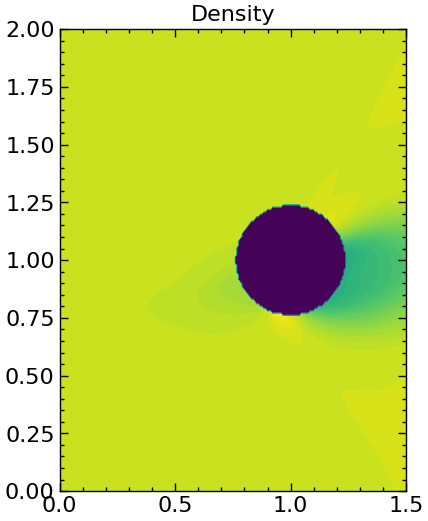

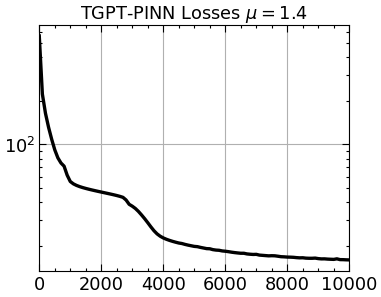

0.26 stopped at epoch: 0 | gpt_loss: 451.6509704589844
0.26 stopped at epoch: 2000 | gpt_loss: 57.10319519042969
layer1:tensor([[ 5.1987e-01,  1.1255e-01, -1.2164e-01],
        [ 4.4664e-03,  9.1141e-01,  1.4725e-01],
        [-5.8020e-04,  3.0478e-02,  1.0289e+00]], device='cuda:0') and tensor([-0.0264, -0.0168,  0.0089], device='cuda:0') and layer3:tensor([[0.8179]], device='cuda:0')
0.26 stopped at epoch: 4000 | gpt_loss: 56.17741775512695
layer1:tensor([[ 5.0852e-01,  1.1739e-01, -1.2445e-01],
        [ 1.0659e-02,  9.1530e-01,  1.5276e-01],
        [ 2.2233e-04,  3.8928e-02,  1.0256e+00]], device='cuda:0') and tensor([-0.0279, -0.0252,  0.0025], device='cuda:0') and layer3:tensor([[0.6836]], device='cuda:0')
0.26 stopped at epoch: 6000 | gpt_loss: 56.13767623901367
layer1:tensor([[ 5.1006e-01,  1.1654e-01, -1.2590e-01],
        [ 1.0890e-02,  9.1672e-01,  1.4593e-01],
        [ 3.2812e-04,  4.7203e-02,  1.0266e+00]], device='cuda:0') and tensor([-0.0256, -0.0198, -0.0063], device=

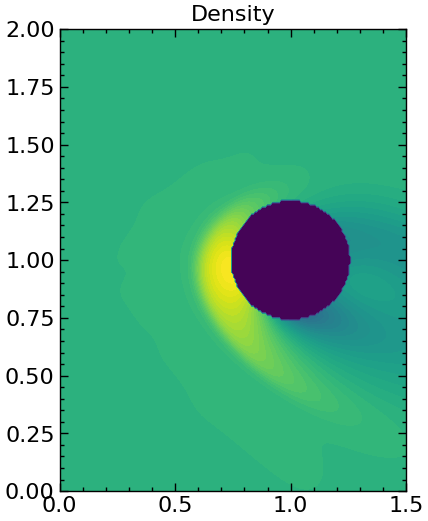

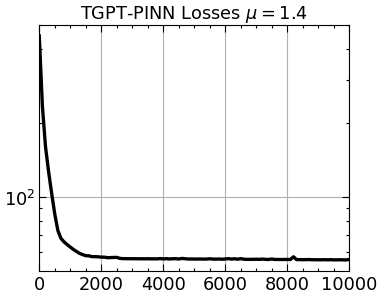

[15.989080429077148, 55.90481948852539]
******************************************************************
0.24 stopped at epoch: 0 | gpt_loss: 1651.52294921875
0.24 stopped at epoch: 2000 | gpt_loss: 19.104358673095703
layer1:tensor([[ 0.2474,  0.1181,  0.0312],
        [-0.0050,  0.9249,  0.0956],
        [ 0.0031, -0.0680,  1.0665]], device='cuda:0') and tensor([-0.1760, -0.0267, -0.0563], device='cuda:0') and layer3:tensor([[0.5165, 0.0343]], device='cuda:0')
0.24 stopped at epoch: 4000 | gpt_loss: 11.924745559692383
layer1:tensor([[ 0.0703,  0.2951, -0.0156],
        [-0.0052,  0.9506,  0.1087],
        [ 0.0024, -0.0532,  1.0584]], device='cuda:0') and tensor([-0.2662, -0.0736, -0.0609], device='cuda:0') and layer3:tensor([[ 0.5224, -0.0096]], device='cuda:0')
0.24 stopped at epoch: 6000 | gpt_loss: 10.470853805541992
layer1:tensor([[ 0.0494,  0.3627,  0.0104],
        [-0.0042,  0.9542,  0.1211],
        [ 0.0017, -0.0423,  1.0552]], device='cuda:0') and tensor([-0.3466, -0.0933

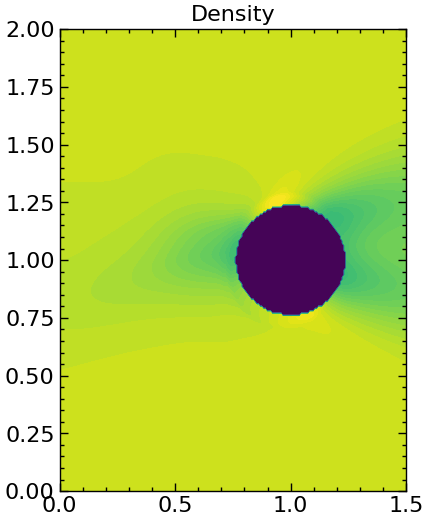

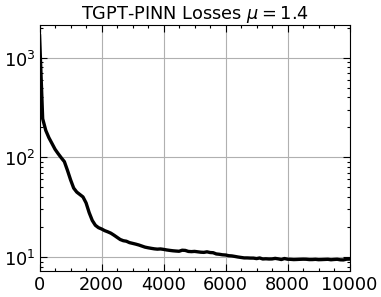

0.26 stopped at epoch: 0 | gpt_loss: 2133.68115234375
0.26 stopped at epoch: 2000 | gpt_loss: 24.40170669555664
layer1:tensor([[ 0.0213, -0.0061, -0.0138],
        [ 0.0655,  0.9747,  0.0271],
        [-0.0182,  0.0733,  0.9031]], device='cuda:0') and tensor([ 0.0117, -0.0559,  0.0023], device='cuda:0') and layer3:tensor([[0.1865, 0.0537]], device='cuda:0')
0.26 stopped at epoch: 4000 | gpt_loss: 7.814553260803223
layer1:tensor([[ 0.0021,  0.0039,  0.0028],
        [-0.0567,  1.1369, -0.0194],
        [ 0.0055,  0.0695,  0.8996]], device='cuda:0') and tensor([-0.0085, -0.0746,  0.0363], device='cuda:0') and layer3:tensor([[0.3199, 0.0045]], device='cuda:0')
0.26 stopped at epoch: 6000 | gpt_loss: 7.246095180511475
layer1:tensor([[ 5.1972e-04,  2.9700e-03,  2.4024e-03],
        [-7.3580e-02,  1.2310e+00, -7.2556e-02],
        [ 6.1548e-03,  5.6330e-02,  8.9498e-01]], device='cuda:0') and tensor([-0.0065, -0.1082,  0.0514], device='cuda:0') and layer3:tensor([[ 0.3711, -0.0010]], device=

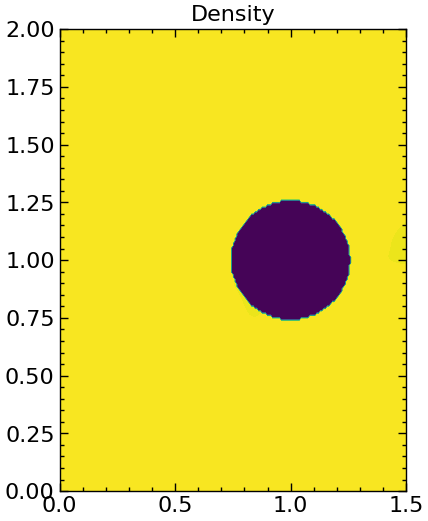

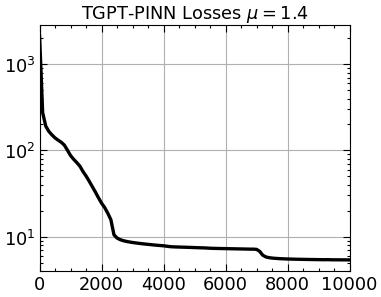

[9.525762557983398, 5.359559535980225]
******************************************************************
0.24 stopped at epoch: 0 | gpt_loss: 1648.68603515625
0.24 stopped at epoch: 2000 | gpt_loss: 16.259559631347656
layer1:tensor([[ 0.8764,  0.0930, -0.0538],
        [-0.0201,  1.0899, -0.0699],
        [-0.0020, -0.0812,  1.0384]], device='cuda:0') and tensor([ 0.0777,  0.0366, -0.0048], device='cuda:0') and layer3:tensor([[0.5174, 0.0285, 0.3420]], device='cuda:0')
0.24 stopped at epoch: 4000 | gpt_loss: 10.381872177124023
layer1:tensor([[ 7.2491e-01,  7.6994e-02, -1.1275e-01],
        [-1.1742e-02,  1.0663e+00, -5.4032e-02],
        [ 5.0553e-04, -8.0089e-02,  1.0339e+00]], device='cuda:0') and tensor([ 0.1442,  0.0372, -0.0006], device='cuda:0') and layer3:tensor([[0.6606, 0.0088, 0.1780]], device='cuda:0')
0.24 stopped at epoch: 6000 | gpt_loss: 9.657390594482422
layer1:tensor([[ 7.1115e-01,  6.7573e-02, -1.0064e-01],
        [-1.3076e-02,  1.0574e+00, -3.8540e-02],
        [-7

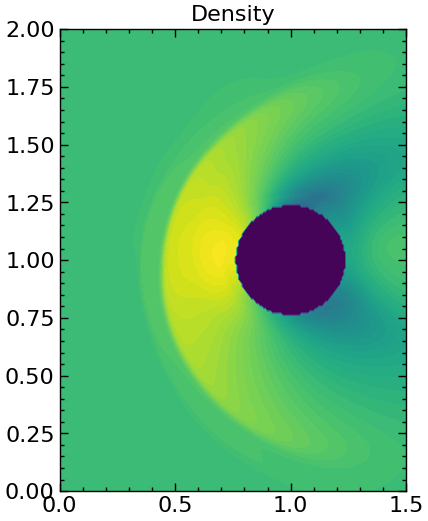

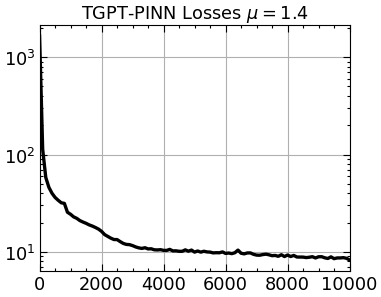

0.26 stopped at epoch: 0 | gpt_loss: 1009.9275512695312
0.26 stopped at epoch: 2000 | gpt_loss: 11.802437782287598
layer1:tensor([[ 3.3729e-02,  1.8936e-01,  6.1281e-02],
        [ 3.2077e-03,  9.9747e-01,  1.7354e-02],
        [-3.1445e-04,  3.4217e-02,  9.2845e-01]], device='cuda:0') and tensor([-0.2049, -0.0370,  0.0746], device='cuda:0') and layer3:tensor([[0.2966, 0.0359, 0.4153]], device='cuda:0')
0.26 stopped at epoch: 4000 | gpt_loss: 7.67777156829834
layer1:tensor([[ 0.0487,  0.2435,  0.0548],
        [-0.0045,  0.9539,  0.0303],
        [-0.0030,  0.0236,  0.9321]], device='cuda:0') and tensor([-0.2606,  0.0116,  0.0863], device='cuda:0') and layer3:tensor([[0.2753, 0.0233, 0.4070]], device='cuda:0')
0.26 stopped at epoch: 6000 | gpt_loss: 6.492330551147461
layer1:tensor([[0.0403, 0.2779, 0.0542],
        [0.0057, 0.9501, 0.0287],
        [0.0019, 0.0175, 0.9349]], device='cuda:0') and tensor([-0.2907,  0.0204,  0.0908], device='cuda:0') and layer3:tensor([[0.2951, 0.0142, 0.

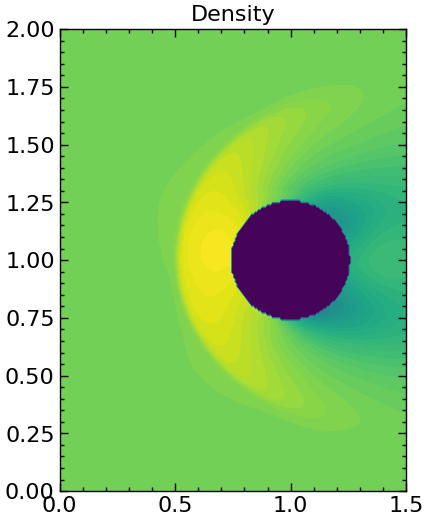

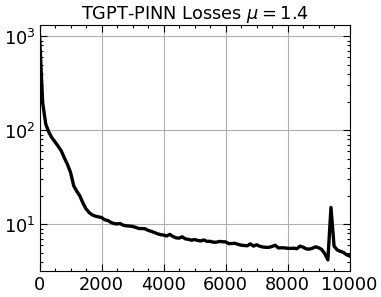

[8.286012649536133, 4.595293998718262]
******************************************************************
0.24 stopped at epoch: 0 | gpt_loss: 861.8272094726562
0.24 stopped at epoch: 2000 | gpt_loss: 5.376959800720215
layer1:tensor([[ 1.0507,  0.0396, -0.0480],
        [-0.0259,  1.0646, -0.0251],
        [-0.0133, -0.0682,  1.0023]], device='cuda:0') and tensor([0.0703, 0.0192, 0.0388], device='cuda:0') and layer3:tensor([[0.4466, 0.0040, 0.1519, 0.3387]], device='cuda:0')
0.24 stopped at epoch: 4000 | gpt_loss: 4.016671180725098
layer1:tensor([[ 1.0352,  0.0415, -0.0581],
        [-0.0210,  1.0315, -0.0187],
        [-0.0074, -0.0712,  0.9883]], device='cuda:0') and tensor([0.0671, 0.0392, 0.0546], device='cuda:0') and layer3:tensor([[ 0.3782, -0.0019,  0.1146,  0.4496]], device='cuda:0')
0.24 stopped at epoch: 6000 | gpt_loss: 2.9129016399383545
layer1:tensor([[ 1.0576,  0.0492, -0.0354],
        [-0.0157,  0.9991, -0.0169],
        [-0.0042, -0.0709,  0.9805]], device='cuda:0') an

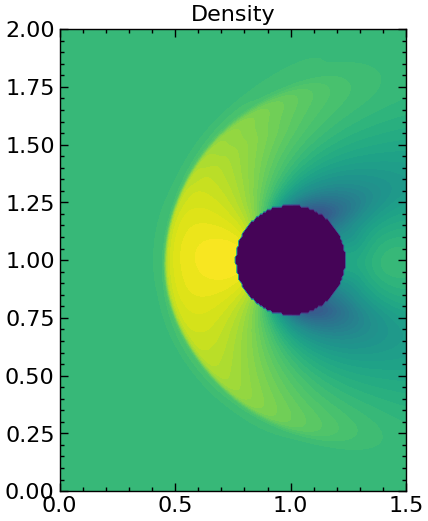

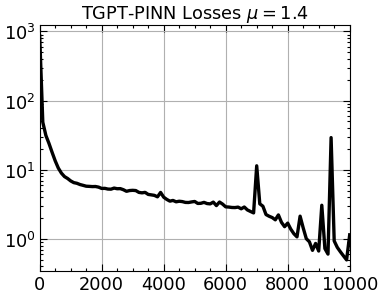

0.26 stopped at epoch: 0 | gpt_loss: 604.6472778320312
0.26 stopped at epoch: 2000 | gpt_loss: 18.553207397460938
layer1:tensor([[ 0.2847,  0.0547, -0.0166],
        [ 0.1022,  0.9058,  0.1146],
        [-0.3004, -0.0473,  1.1443]], device='cuda:0') and tensor([-0.0085, -0.0588, -0.0616], device='cuda:0') and layer3:tensor([[0.1349, 0.1186, 0.1048, 0.4409]], device='cuda:0')
0.26 stopped at epoch: 4000 | gpt_loss: 10.112264633178711
layer1:tensor([[ 0.2971,  0.0124,  0.0099],
        [-0.0236,  0.7444,  0.2163],
        [-0.1513, -0.1848,  1.1046]], device='cuda:0') and tensor([-0.0226,  0.0516,  0.1055], device='cuda:0') and layer3:tensor([[0.1238, 0.0813, 0.2656, 0.3312]], device='cuda:0')
0.26 stopped at epoch: 6000 | gpt_loss: 4.45744514465332
layer1:tensor([[ 0.2534, -0.0092,  0.1008],
        [-0.0770,  0.7047,  0.2986],
        [-0.0602, -0.1946,  1.0988]], device='cuda:0') and tensor([-0.0584,  0.0317,  0.1134], device='cuda:0') and layer3:tensor([[0.0539, 0.0446, 0.5404, 0.238

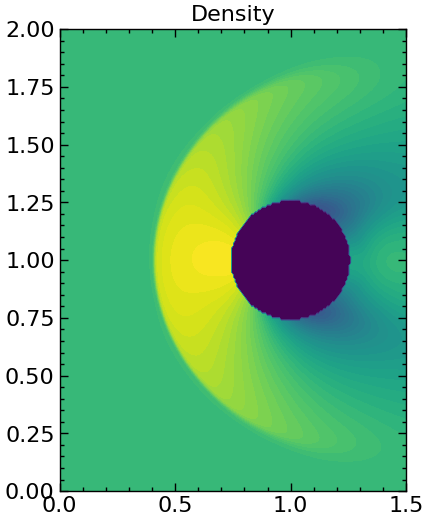

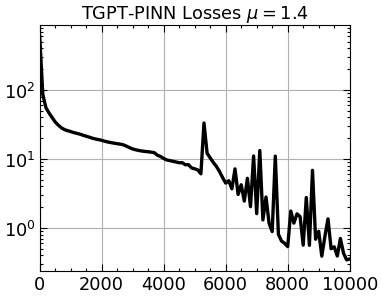

[1.1477344036102295, 0.3549712896347046]
******************************************************************
0.24 stopped at epoch: 0 | gpt_loss: 1243.73974609375
0.24 stopped at epoch: 2000 | gpt_loss: 4.213438987731934
layer1:tensor([[ 0.4212,  0.0889, -0.0725],
        [ 0.0514,  0.9271,  0.0231],
        [ 0.1290, -0.0449,  0.9310]], device='cuda:0') and tensor([-0.0364,  0.0269,  0.0843], device='cuda:0') and layer3:tensor([[0.2008, 0.0190, 0.1202, 0.4963, 0.0687]], device='cuda:0')
0.24 stopped at epoch: 4000 | gpt_loss: 1.5833625793457031
layer1:tensor([[ 0.3029,  0.0608, -0.0510],
        [ 0.0709,  0.9146,  0.0423],
        [ 0.0737, -0.0577,  0.8942]], device='cuda:0') and tensor([-0.0405,  0.0172,  0.1501], device='cuda:0') and layer3:tensor([[0.1016, 0.0139, 0.1175, 0.6978, 0.0119]], device='cuda:0')
0.24 stopped at epoch: 6000 | gpt_loss: 1.2199461460113525
layer1:tensor([[ 0.2610,  0.0822, -0.0536],
        [ 0.0740,  0.9361,  0.0164],
        [ 0.0718, -0.0799,  0.9027]],

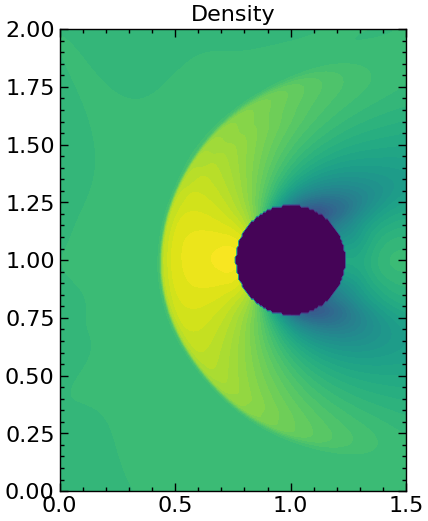

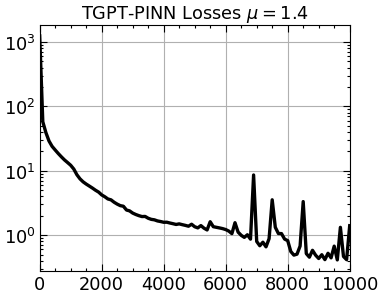

0.26 stopped at epoch: 0 | gpt_loss: 347.1536560058594
0.26 stopped at epoch: 2000 | gpt_loss: 1.7745389938354492
layer1:tensor([[ 0.8508, -0.0381,  0.0450],
        [-0.1021,  0.9177,  0.0091],
        [ 0.0770,  0.0055,  0.9805]], device='cuda:0') and tensor([ 0.0270,  0.0520, -0.0139], device='cuda:0') and layer3:tensor([[0.1340, 0.0172, 0.4486, 0.2481, 0.0983]], device='cuda:0')
0.26 stopped at epoch: 4000 | gpt_loss: 1.2094652652740479
layer1:tensor([[ 0.9878, -0.0415,  0.0164],
        [-0.0925,  0.9112,  0.0132],
        [ 0.0029,  0.0384,  0.9069]], device='cuda:0') and tensor([0.0264, 0.0600, 0.0377], device='cuda:0') and layer3:tensor([[0.1081, 0.0114, 0.6364, 0.1655, 0.0523]], device='cuda:0')
0.26 stopped at epoch: 6000 | gpt_loss: 1.1013355255126953
layer1:tensor([[ 0.9654, -0.0544,  0.0171],
        [-0.0713,  0.9063,  0.0152],
        [ 0.0022,  0.0353,  0.9000]], device='cuda:0') and tensor([0.0439, 0.0583, 0.0476], device='cuda:0') and layer3:tensor([[0.0741, 0.0094, 0

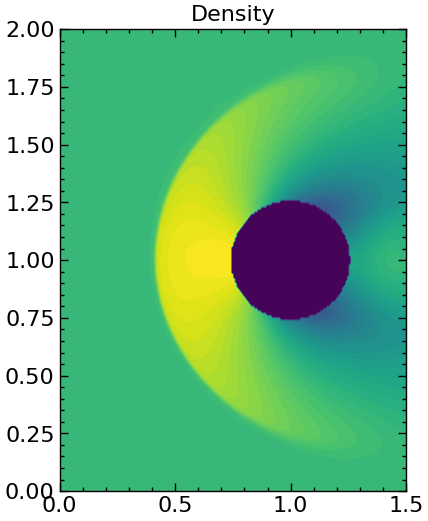

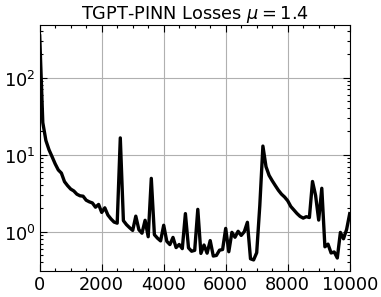

[1.4013853073120117, 1.7106406688690186]


In [5]:
lr_pinn     = 0.001
epochs_pinn = 4000
tol_pinn    = 1e-2

layers_pinn = np.array([3, 90,90,90,90,90,90, 4])

lr_vgpt          = 0.001
epochs_vgpt      = 10000
tol_vgpt         = 1e-2

for i in range(0, number_of_neurons):
    print("******************************************************************")
    ########################### Full PINN Training ############################
    layers_gpt = np.array([3, i+1, 4])
    c_initial  = torch.full((1,i+1), 1/(i+1))
    nu_loss = []

    gpt_train_time_1 = time.perf_counter()
    for rd in nu_training:

        xlimits = np.array([[0.,Tend],[0.0, Lx], [0,Ly]])  #interal
        sampling = LHS(xlimits=xlimits)
        x_int_train = sampling(num_int)
        A = []
        for i in range(num_int):
            x = x_int_train[i,1]
            y = x_int_train[i,2]
            if ((x - rx)**2 +(y-ry)**2< rd**2):
                A.append(i)
        x_int_train = np.delete(x_int_train,A,axis=0)

        xlimits = np.array([[0.,0.0],[0.0,Lx], [0.0,Ly]])  #interal
        sampling = LHS(xlimits=xlimits)
        x_ic_train = sampling(num_ib)
        A = []
        for i in range(num_ib):
            x = x_ic_train[i,1]
            y = x_ic_train[i,2]
            if ((x - rx)**2 +(y-ry)**2< rd**2):
                A.append(i)
        x_ic_train = np.delete(x_ic_train,A,axis=0)
        x_bcI_train,sin_bcI_train,cos_bcI_train = BD_circle(Tend,rx,ry,rd,num_ib)

        rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)  
        x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

        x_bcI_train = torch.tensor(x_bcI_train, requires_grad=True, dtype=torch.float32).to(device)
        sin_bcI_train = torch.tensor(sin_bcI_train, dtype=torch.float32).to(device)
        cos_bcI_train = torch.tensor(cos_bcI_train, dtype=torch.float32).to(device)

        rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
        u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
        v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
        p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)
        x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)

        VGPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial, gamma=1.4).to(device)

        vgpt_losses = gpt_train(VGPT_PINN, rd, x_int_train,x_ic_train,rho_ic_train,u_ic_train,v_ic_train,p_ic_train,x_bcL_train, rho_bcL_train,u_bcL_train,v_bcL_train,p_bcL_train,x_bcI_train, sin_bcI_train,cos_bcI_train, epochs_vgpt, lr_vgpt, tol_vgpt)

        nu_loss.append(vgpt_losses[0].item())
        
        u = to_numpy(VGPT_PINN(ux_test))
        E_plot_2d(x_test,x_grid,y_grid, u[:,0], Nd, rx,ry,rd, title=fr"Density")
        #E_plot_2d(x_test,x_grid,y_grid, u[:,1], Nd, rx,ry,rd, title=fr"Presure")
        #E_plot_2d(x_test,x_grid,y_grid, u[:,2], Nd, rx,ry,rd, title=fr"Vx")
        #E_plot_2d(x_test,x_grid,y_grid, u[:,3], Nd, rx,ry,rd, title=fr"Vy")

        loss_plot(vgpt_losses[1], vgpt_losses[2], dpi=80, figsize=(5,4),title=fr"VGPT-PINN Losses $\mu={round(nu,3)}$")
    print(nu_loss)

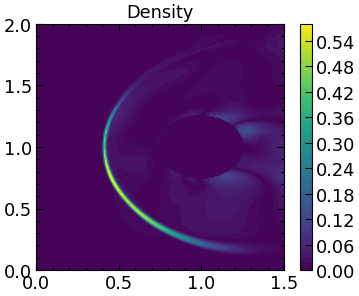

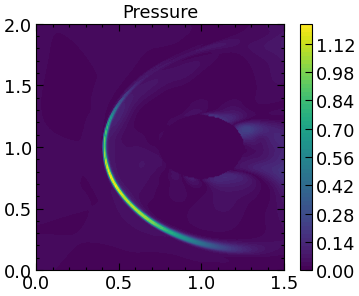

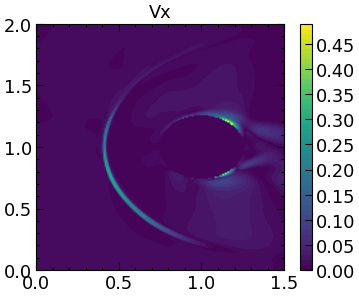

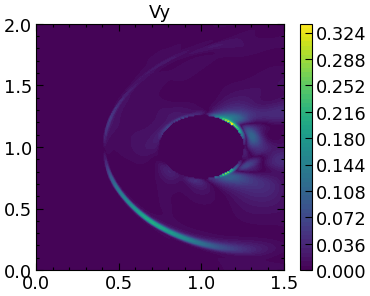

In [9]:
with open('PINN_Euler_circle026.pkl', 'rb') as f:
    PINN = pickle.load(f)
pinn_sol = to_numpy(PINN[0](ux_test))
%run E_Plotting.py
E_plot_2d(x_test,x_grid,y_grid, abs(u[:,0]-pinn_sol[:,0]), Nd, rx,ry,rd, title=fr"Density")
E_plot_2d(x_test,x_grid,y_grid, abs(u[:,1]-pinn_sol[:,1]), Nd, rx,ry,rd, title=fr"Pressure")
E_plot_2d(x_test,x_grid,y_grid, abs(u[:,2]-pinn_sol[:,2]), Nd, rx,ry,rd, title=fr"Vx")
E_plot_2d(x_test,x_grid,y_grid, abs(u[:,3]-pinn_sol[:,3]), Nd, rx,ry,rd, title=fr"Vy")

In [6]:
'''
Nd = 600
T = 0.4
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(TGPT_PINN(x_test))


x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0          
uo1 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,1]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo2 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()  

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,2]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo3 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,3]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo4 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()
'''

'\nNd = 600\nT = 0.4\nt = np.linspace(T, T, 1)                                   # Partitioned spatial axis\nx = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis\ny = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis\nt_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]\nT = t_grid.flatten()[:, None]                                         # Vectorized x_grid\nX = x_grid.flatten()[:, None]                                         # Vectorized x_grid\nY = y_grid.flatten()[:, None]                                         # Vectorized x_grid\nx_test = np.hstack((T,X,Y))                                            # Vectorized whole domain\nx_test = torch.tensor(x_test, dtype=torch.float32).to(device)\nu = to_numpy(TGPT_PINN(x_test))\n\n\nx_test = np.hstack((T,X,Y))                                            # Vectorized whole domain\nue = np.zeros((Nd,Nd))\nfor j in range(0,

In [7]:
'''
Nd = 600
T = 1
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(PINN(x_test))


x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0          
uo1 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,1]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo2 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()  

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,2]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo3 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,3]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo4 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()
'''

'\nNd = 600\nT = 1\nt = np.linspace(T, T, 1)                                   # Partitioned spatial axis\nx = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis\ny = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis\nt_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]\nT = t_grid.flatten()[:, None]                                         # Vectorized x_grid\nX = x_grid.flatten()[:, None]                                         # Vectorized x_grid\nY = y_grid.flatten()[:, None]                                         # Vectorized x_grid\nx_test = np.hstack((T,X,Y))                                            # Vectorized whole domain\nx_test = torch.tensor(x_test, dtype=torch.float32).to(device)\nu = to_numpy(PINN(x_test))\n\n\nx_test = np.hstack((T,X,Y))                                            # Vectorized whole domain\nue = np.zeros((Nd,Nd))\nfor j in range(0,Nd):\n 